<a href="https://colab.research.google.com/github/manohar8642/us-foods-webscraping/blob/main/US_Foods_POC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **US Foods - Restaurants Data Extraction and Preparation**

This notebook will walk you through the process of extracting restaurants data like name, address, city, state, zipcode, latitude & longitude, ratings, cuisines etc. through different APIs and web scraping. 

This extracted data is then processed to structured format which can be used for Analytical Consumption

***Contents***

1. Extract Data from Yelp API, Website Scraping and Tabular Format Representation of Data Collected 
2. Extract Data from Other Resources and Merging them together
3. Data Prepartion for Analytical Consumption and Feature Engineering
5. EDA

## **1. Extract Data from Yelp API and Website Scraping and Tabular Format Representation of Data Collected**

Yelp has different APIs for different purpose. For our problem statement we will be using two APIs - Business Search API and Business Details API.

Business Search API is used to get the details of restaurants present in the given search location.

Business Details API is used to get the details of the specific restaurant by pasing the Business ID obtained from the Business Search API

*Reference* - [LINK](https://www.yelp.com/developers/documentation/v3/business)



### **1.1 Yelp API**

***Code Flow***

1. Pass the SEARCH LOCATION ex. San Francisco etc. and SEARCH TERM ie 'food' in the defaults section
2. Send GET request to the Business Search API passing location and term
3. Pass each Business ID present in the response of the step 2 in GET request to Business Details to obtain details of restaurants
4. End output is JSON response which contains restaurant information like name, address, latitude, longitude, ratings, cuisine etc

In [ ]:
# import required packages

from __future__ import print_function
import argparse
import json
import pprint
import requests
import sys
import urllib
import pandas as pd
import numpy as np
import re
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn import preprocessing

# This client code can run on Python 2.x or 3.x.  Your imports can be
# simpler if you only need one of those.
try:
    # For Python 3.0 and later
    from urllib.error import HTTPError
    from urllib.parse import quote
    from urllib.parse import urlencode
except ImportError:
    # Fall back to Python 2's urllib2 and urllib
    from urllib2 import HTTPError
    from urllib import quote
    from urllib import urlencode

# import required packages for web scraping
from bs4 import BeautifulSoup
import requests
import csv
import pandas as pd
import re

# import packages required for scraping google search ui
!pip install google-search-results
from serpapi.google_search_results import GoogleSearchResults

  Created wheel for google-search-results: filename=google_search_results-1.8.3-cp36-none-any.whl size=15516 sha256=774497e9c7494a0db07b2d1e458dd9c3c71e8885ebd4eba98c802912cb7e02fd
  Stored in directory: /root/.cache/pip/wheels/45/26/3b/ee21c4180507279494b170ee818e0a4c0442a0586bce53945a
Successfully built google-search-results


In [ ]:
# Yelp uses private keys to authenticate requests (API Key)
# You can find it on https://www.yelp.com/developers/v3/manage_app

# Set API Key

API_KEY= "J_1E_bEc08K-fNoQbmx7DTQfX50W0xGM5ZssMBTKEkQ3FANNisiY5KqxPTMCAdFSyeCkMhOKOHYWzlyMPS4iExVfNzP4mfH30ApICsVK2OTyPz_baSJ5wMcyqweAX3Yx" 


In [ ]:
# API constants, you shouldn't have to change these.

API_HOST = 'https://api.yelp.com'
SEARCH_PATH = '/v3/businesses/search'
BUSINESS_PATH = '/v3/businesses/'  # Business ID will come after slash.
REVIEWS_PATH = '/reviews'   # This will come after Business ID


In [ ]:
# Functions for Yelp API

def request(host, path, api_key, url_params=None):
    """Given your API_KEY, send a GET request to the API.
    Args:
        host (str): The domain host of the API.
        path (str): The path of the API after the domain.
        API_KEY (str): Your API Key.
        url_params (dict): An optional set of query parameters in the request.
    Returns:
        dict: The JSON response from the request.
    Raises:
        HTTPError: An error occurs from the HTTP request.
    """
    url_params = url_params or {}
    url = '{0}{1}'.format(host, quote(path.encode('utf8')))
    headers = {
        'Authorization': 'Bearer %s' % api_key,
    }

    response = requests.request('GET', url, headers=headers, params=url_params)

    return response.json()


def search(api_key, term, location):
    """Query the Search API by a search term and location.
    Args:
        term (str): The search term passed to the API.
        location (str): The search location passed to the API.
    Returns:
        dict: The JSON response from the request.
    """

    url_params = {
        'term': term.replace(' ', '+'),
        'location': location.replace(' ', '+'),
        'limit': SEARCH_LIMIT
    }
    return request(API_HOST, SEARCH_PATH, api_key,url_params)


def get_business(api_key, business_id):
    """Query the Business API by a business ID.
    Args:
        business_id (str): The ID of the business to query.
    Returns:
        dict: The JSON response from the request.
    """
    business_path = BUSINESS_PATH + business_id

    return request(API_HOST, business_path, api_key)
    
    
def get_reviews(api_key, business_id):
    """Query the Reviews API by a business ID.
    Args:
        business_id (str): The ID of the business to query.
    Returns:
        dict: The JSON response from the request.
    """
    reviews_path = BUSINESS_PATH + business_id + REVIEWS_PATH

    return request(API_HOST, reviews_path, api_key)


def query_api(term, location):
    """Queries the API by the input values from the user.
    Args:
        term (str): The search term to query.
        location (str): The location of the business to query.
    """
    response = search(API_KEY, term, location)

    businesses = response.get('businesses')
    
    print("Found total {} restuarants\n-----------********------------".format(len(businesses))) # Prints no.of restaurants data found in response

    if not businesses:
        print(u'No businesses for {0} in {1} found.'.format(term, location))
        return

    api_result = [] # stores the json response of pi

    for i in range(len(businesses)):
        business_id = businesses[i]['id']
        
        business_response = get_business(API_KEY, business_id)
        # reviews_response = get_reviews(API_KEY, business_id) # use if you want to extract reviews

        api_result.append(business_response) # append response to list

    # print result of one restaurant
    print("Sample JSON response of one restaurant\n")
    pprint.pprint(api_result[0], indent=3)

    # store result in json
    import json
    with open('yelp_sf_14_10_2020_v3.json', 'w') as fout:
        json.dump(api_result, fout)


def main():

    try:
        query_api(DEFAULT_TERM, DEFAULT_LOCATION)
    except HTTPError as error:
        sys.exit(
            'Encountered HTTP error {0} on {1}:\n {2}\nAbort program.'.format(
                error.code,
                error.url,
                error.read(),
            )
        )


In [ ]:
# Defaults for our query.
DEFAULT_TERM = 'food'
DEFAULT_LOCATION = 'San Francisco, CA'
SEARCH_LIMIT = 50

main() # call the function

Found total 50 restuarants
-----------********------------
Sample JSON response of one restaurant

{  'alias': 'tacorea-chinatown-san-francisco',
   'categories': [  {'alias': 'mexican', 'title': 'Mexican'},
                    {'alias': 'korean', 'title': 'Korean'},
                    {'alias': 'latin', 'title': 'Latin American'}],
   'coordinates': {'latitude': 37.797972, 'longitude': -122.407453},
   'display_phone': '(415) 506-9642',
   'hours': [  {  'hours_type': 'REGULAR',
                  'is_open_now': False,
                  'open': [  {  'day': 1,
                                'end': '1430',
                                'is_overnight': False,
                                'start': '1130'},
                             {  'day': 1,
                                'end': '2000',
                                'is_overnight': False,
                                'start': '1700'},
                             {  'day': 2,
                                'end': '1430

### **1.2 Tabular Representation of Yelp API response**

Fron the JSON we got from step 1.1 we are going to create a dataframe which stores the following fields data

* name ------------- Name of the Restaurant
* city ----------------- Restaurant city
* state --------------- Restaurant state
* latitude ------------ Latitude of restaurant
* longitude --------- Longitude of restaurant
* zipcode ------------ Zipcode of restaurant
* price ----------------- Price category of restaurant
* hours ---------------- Restaurant operating hours in the form of dictionary
* transactions ----- Restaurant transaction type (any type - pickup, delivery, restaurant_reservation)
* categories -------- Restaurant cuisine
* ratings -------------- Restaurant rating in the scale of 1 - 5
* reviews_count --- Count of ratings of the restaurant
* url----------------------- Yelp url of the restaurant



In [ ]:
# code to parse response of each restaurant api

import json

# read json file which is created in previous step
with open('yelp_sf_14_10_2020_v3.json') as f:
  data = json.load(f)

data_rows = [] # list to store data fields

for i in range(len(data)): # iterate over all responses in JSON file
# for i in range(3):

  business_details = data[i] # response of each restaurant

  try:
    ''' latitude of the restaurant'''

    latitude = business_details['coordinates']['latitude']
  except:
    latitude = 0
  
  try:
    ''' longitude of the restaurant'''

    longitude = business_details['coordinates']['longitude']
  except:
    longitude = 0

  try:
    ''' zipcode of the restaurant'''

    zipcode = business_details['location']['zip_code']
  except:
    zipcode = 0

  try:
    ''' city of the restaurant'''

    city = business_details['location']['city']
  except:
    city = 'N/A'

  try:
    ''' state of the restaurant'''

    state = business_details['location']['state']
  except:
    state = 'N/A'
  
  try:
    ''' yelp url of the restaurant'''

    url = business_details['url']
  except:
    url = 'N/A'


  try:
    ''' name of the restaurant'''

    name = business_details['name']
  except:
    name = 'N/A'

  try:
    ''' yelp rating of the restaurant'''

    ratings = business_details['rating']
  except:
    ratings = 0

  try:
    ''' count of reviews of the restaurant'''

    review_count = business_details['review_count']
  except:
    review_count = 0

  try:
    ''' Type of restaurant ie. pickup, delivery or restaurant_reservation'''

    transactions = business_details['transactions']
  except:
    transactions = 'N/A'

  try:
    ''' Cuisine of the restaurant'''

    categories = [k['title'] for k in business_details['categories']]
  except:
    categories = 'N/A'
  
  try:
    ''' Operating hours of the restaurant'''

    hours = business_details['hours'][0]['open']
  except:
    hours = 'N/A'

  try:
    ''' Categorical price of the restaurant - $, $$, $$$, $$$$, $$$$$'''

    price = business_details['price']
  except:
    price = 'N/A'

  # append row data
  data_rows.append([name,city,state,zipcode,latitude,longitude,price,hours,transactions,categories,ratings,review_count,url]) # append to list

# create dataframe
df = pd.DataFrame(data_rows, columns = ['name','city','state','zipcode','latitude','longitude','price','hours','transactions','categories','ratings','review_count','url'])
df.head(3)

,name,city,state,zipcode,latitude,longitude,price,hours,transactions,categories,ratings,review_count,url
0,Tacorea - Chinatown,San Francisco,CA,94133,37.797972,-122.407453,N/A,"[{'is_overnight': False, 'start': '1130', 'end...",[],"[Mexican, Korean, Latin American]",4.5,11,https://www.yelp.com/biz/tacorea-chinatown-san...
1,Hot Sauce and Panko,San Francisco,CA,94109,37.794505,-122.417957,$$,"[{'is_overnight': False, 'start': '1130', 'end...","[pickup, delivery]","[Chicken Wings, Waffles, Sandwiches]",4.5,1158,https://www.yelp.com/biz/hot-sauce-and-panko-s...
2,Beretta Pop Up,San Francisco,CA,94117,37.775749,-122.438250,N/A,"[{'is_overnight': False, 'start': '1600', 'end...",[restaurant_reservation],"[Italian, Pizza, Breakfast & Brunch]",4.5,33,https://www.yelp.com/biz/beretta-pop-up-san-fr...


### **1.3 Yelp Website Scraping and Tabular Representation**

Following fields are extracted from scraping and stored in the dataframe created in step 1.2

1. yelp_written_reviews ------------ written reviews extracted from yelp website
2. yelp_written_reviews_count ----------- count of written reviews extracted from yelp website

***Code Flow***
1. Each url from the url column of the dataframe created in step 1.2 is passed to getAndParseURL function which returns html text of the website
2. written reviews are then scraped from the html text and stored in column written_reviews

In [ ]:
# Function for Yelp Web Scraping

def getAndParseURL(url): 
  ''' Send url of the site to be parsed

      Input : url of the site
      Output : parsed html '''

  try:
    result = requests.get(url)
    soup = BeautifulSoup(result.text, 'html.parser')
    return(soup)
  except:
    print("URL Not Accessible")

In [ ]:
rl = [] # list to store written reviews
rc = [] # list to store count of written reviews

# get url
for url in df['url']:

  # Call scrape function to extract written reviews and count
  soup = getAndParseURL(url)

  try:
    written_reviews = [i.find('span').text for i in soup.find_all('p', class_ = 'lemon--p__373c0__3Qnnj text__373c0__2Kxyz comment__373c0__3EKjH text-color--normal__373c0__3xep9 text-align--left__373c0__2XGa-')]
    written_reviews_count = len(written_reviews)
  except:
    written_reviews = []
    written_reviews_count = len(written_reviews)
  
  rl.append(written_reviews)
  rc.append(written_reviews_count)

df['yelp_written_reviews'] = rl
df['yelp_written_reviews_count'] = rc

df.head(3)
  

,name,city,state,zipcode,latitude,longitude,price,hours,transactions,categories,ratings,review_count,url,yelp_written_reviews,yelp_written_reviews_count
0,Tacorea - Chinatown,San Francisco,CA,94133,37.797972,-122.407453,N/A,"[{'is_overnight': False, 'start': '1130', 'end...",[],"[Mexican, Korean, Latin American]",4.5,11,https://www.yelp.com/biz/tacorea-chinatown-san...,"[Few things.. If you're a native, then know th...",11
1,Hot Sauce and Panko,San Francisco,CA,94109,37.794505,-122.417957,$$,"[{'is_overnight': False, 'start': '1130', 'end...","[pickup, delivery]","[Chicken Wings, Waffles, Sandwiches]",4.5,1158,https://www.yelp.com/biz/hot-sauce-and-panko-s...,[You know a place is good when the entire stre...,20
2,Beretta Pop Up,San Francisco,CA,94117,37.775749,-122.438250,N/A,"[{'is_overnight': False, 'start': '1600', 'end...",[restaurant_reservation],"[Italian, Pizza, Breakfast & Brunch]",4.5,33,https://www.yelp.com/biz/beretta-pop-up-san-fr...,[I was so stoked to find out that a pop up was...,20


## **2. Extract Data from Other Sources and Merging All Sources Data Together**

Ratings and Reviews count extracted from only Yelp website will be insuficient and baised to rely upon. Therefore data from other relevant websites like Google, Uber Eats, GrubHub etc are also extracted. Average rating is taken into consideration during Analytical Consuption

### **2.1 Extract Data from Other Sources**

In this code block we will extract data by scraping google search UI using [SerpAPI](https://serpapi.com/).

Extracted data contains following fields.
1. google_rating --------------- restaurant rating given by google
2. google_review --------------- no.of google reviews given to the restaurant
3. google_service_options ------ what type of transaction restaurant accepts (ie. pickup or delivery or dine-in)
4. google_price ---------------- google price category of restaurant
5. google_writtten_reviews -------- written reviews extracted from google 
6. count_written_reviews ---------- no.of written reviews extracted
7. yelp_rating ------------- restaurant rating given by yelp
8. yelp_reviews ------------- no.of yelp reviews given to restaurant
9. yelp_price --------------- restaurant price category given by yelp
10. grubhub_rating ------------- restaurant rating given by grubhub
11. grubhub_reviews ------------- no.of grubhub reviews given to restaurant
12. grubhub_price --------------- restaurant price category given by grubhub
13. uber_rating ------------- restaurant rating given by uber
14. uber_reviews ------------- no.of uber reviews given to restaurant
15. uber_price --------------- restaurant price category given by uber
10. trip_rating ------------- restaurant rating given by trip adviser
11. trip_reviews ------------- no.of trip adviser reviews given to restaurant
12. trip_price --------------- restaurant price category given by trip adviser
13. facebook_rating ------------- restaurant rating given by facebook
14. facebook_reviews ------------- no.of facebook reviews given to restaurant
15. facebook_price --------------- restaurant price category given by facebook

***Code Flow***
1. Each restaurant name is sent as parameter to SerpAPI which returns JSON response
2. From the JSON response, data related to above fields is extracted and stored in a new dataframe



In [ ]:
# import packages
import re

# scraping google search ui

restaurants = df['name']

l = [] # list to store values

for i in range(0,restaurants.shape[0]):
# for i in range(4):

    # print("----------------------"+ str(i)+ "--------------------")

    params = {
        "q": restaurants[i],
        "location": "San Francisco, California, United States",
        "hl": "en",
        "gl": "us",
        "google_domain": "google.com",
        "api_key": "d50e22ea1b044bc39c0bea7236241abb3720b7892b162db51148ddbe1258e654"
    }

    client = GoogleSearchResults(params)
    results = client.get_dict()

    # pprint.pprint(results, indent=3)

    name = restaurants[i]

    try:
        ''' Google Rating'''

        google_rating = results['knowledge_graph']['rating']
        # print("Google Rating: {}".format(google_rating))
    except:
        google_rating = 0

    try:
        ''' No.of reviews'''

        google_rating_count = results['knowledge_graph']['review_count']
        # print("Google Rating Count: {}".format(google_rating_count))
    except:
        google_rating_count = 0

    try:
        ''' whether restaurant id dine-in or takeaway etc'''

        google_service_options = results['knowledge_graph']['service_options']
        # print("Service Options: {}".format(service_options))
    except:
        google_service_options = 'N/A'

    try:
        ''' price category by google'''

        google_price = results['knowledge_graph']['price']
        # print("Google Price: {}".format(google_price))
    except:
        google_price = 'N/A'
    
    try:
        ''' google written reviews'''

        google_written_reviews = [i['summary'] for i in results['knowledge_graph']['user_reviews']]
        # print("User Reviews: {}".format(google_written_reviews))
    except:
        google_written_reviews = 'N/A'

    y_rating = " "
    gr_rating = " "
    u_rating = " "
    t_rating = " "
    f_rating = " "
    y_rat = None
    y_rev = None
    y_p = 'N/A'
    gr_rat = None
    gr_rev = None
    gr_p = 'N/A'
    u_rat = None
    u_rev = None
    u_p = 'N/A'
    t_rat = None
    t_rev = None
    t_p = 'N/A'
    f_rat = None
    f_rev = None
    f_p = 'N/A'

    
    for i in range(0,len(results['organic_results'])):
        # try:
            # print(results['organic_results'][i])
            if (results['organic_results'][i]['displayed_link'].split(' ')[0] == 'www.yelp.com') & (y_rating == " "):
              try:
                y_rating = results['organic_results'][i]['rich_snippet']['top']['extensions'][0]
                y_rating = y_rating[y_rating.find('Rating:'):]
                y_rating = y_rating.split(' ')
                for i in range(len(y_rating)):
                  if y_rating[i]=='Rating:':
                    y_rat = float(y_rating[i+1])
                    # print(y_rat)

                  if y_rating[i]=='votes' or y_rating[i]=='reviews':
                    y_rev = y_rating[i-1]
                    y_rev = int(y_rev[1:].replace(',',''))
                    # print(y_rev)
                    # print(type(y_rev))

                  if y_rating[i]=='range:':
                    y_p = re.findall(r'\$+',' '.join(y_rating[i+1:]))[0]
                    # print(y_p)
                
                # print("Yelp: {}".format(y_rating))
              except:
                None

            elif (results['organic_results'][i]['displayed_link'].split(' ')[0] == 'www.grubhub.com') & (gr_rating == " "):
              try:
                gr_rating = results['organic_results'][i]['rich_snippet']['top']['extensions'][0]
                gr_rating = gr_rating[gr_rating.find('Rating:'):]
                gr_rating = gr_rating.split(' ')
                for i in range(len(gr_rating)):
                  if gr_rating[i]=='Rating:':
                    gr_rat = float(gr_rating[i+1])
                    # print(gr_rat)

                  if gr_rating[i]=='votes' or gr_rating[i]=='reviews':
                    gr_rev = gr_rating[i-1]
                    gr_rev = int(gr_rev[1:].replace(',',''))
                    # print(gr_rev)

                  if gr_rating[i]=='range:':
                    gr_p = re.findall(r'\$+',' '.join(gr_rating[i+1:]))[0]
                    # print(gr_p)
                # print("Grubhub: {}".format(gr_rating))
              except:
                None
                
            elif (results['organic_results'][i]['displayed_link'].split(' ')[0] == 'www.ubereats.com') & (u_rating == " "):
              try:
                u_rating = results['organic_results'][i]['rich_snippet']['top']['extensions'][0]
                u_rating = u_rating[u_rating.find('Rating:'):]
                u_rating = u_rating.split(' ')
                for i in range(len(u_rating)):
                  if u_rating[i]=='Rating:':
                    u_rat = float(u_rating[i+1])
                    # print(u_rat)

                  if u_rating[i]=='votes' or u_rating[i]=='reviews':
                    u_rev = u_rating[i-1]
                    u_rev = int(u_rev[1:].replace(',',''))
                    # print(u_rev)

                  if u_rating[i]=='range:':
                    u_p = re.findall(r'\$+',' '.join(u_rating[i+1:]))[0]
                    # print(u_p)
                # print("Ubereats: {}".format(u_rating))
              except:
                None

            elif (results['organic_results'][i]['displayed_link'].split(' ')[0] == 'www.tripadvisor.com') & (t_rating == " "):
              try:
                t_rating = results['organic_results'][i]['rich_snippet']['top']['extensions'][0]
                t_rating = t_rating[t_rating.find('Rating:'):]
                t_rating = t_rating.split(' ')
                for i in range(len(t_rating)):
                  if t_rating[i]=='Rating:':
                    t_rat = float(t_rating[i+1])
                    # print(t_rat)

                  if t_rating[i]=='votes' or t_rating[i]=='reviews':
                    t_rev = t_rating[i-1]
                    t_rev = int(t_rev[1:].replace(',',''))
                    # print(t_rev)

                  if t_rating[i]=='range:':
                    t_p = re.findall(r'\$+',' '.join(t_rating[i+1:]))[0]
                    # print(t_p)
                # print("Tripadvisor: {}".format(t_rating))
              except:
                None

            elif (results['organic_results'][i]['displayed_link'].split(' ')[0] == 'www.facebook.com') & (f_rating == " "):
              try:
                f_rating = results['organic_results'][i]['rich_snippet']['top']['extensions'][0]
                f_rating = f_rating[f_rating.find('Rating:'):]
                f_rating = f_rating.split(' ')
                for i in range(len(f_rating)):
                  if f_rating[i]=='Rating:':
                    f_rat = float(f_rating[i+1])
                    # print(f_rat)

                  if f_rating[i]=='votes' or f_rating[i]=='reviews':
                    f_rev = f_rating[i-1]
                    f_rev = int(f_rev[1:].replace(',',''))
                    # print(f_rev)

                  if f_rating[i]=='range:':
                    f_p = re.findall(r'\$+',' '.join(f_rating[i+1:]))[0]
                    # print(f_p)
                # print("Facebook: {}".format(f_rating))
              except:
                None

            else:
                None
        # except:
        #     None
    
    l.append([name,google_rating,google_rating_count,google_service_options,google_price,google_written_reviews,len(google_written_reviews),y_rat,y_rev,y_p,gr_rat,gr_rev,gr_p,u_rat,u_rev,u_p,t_rat,t_rev,t_p,f_rat,f_rev,f_p])

# create new dataframe
df2 = pd.DataFrame(l, columns = ['name','google_rating','google_reviews','google_service_options','google_price','google_written_reviews','count_google_written_reviews','yelp_rating','yelp_reviews','yelp_price','grubhub_rating','grubhub_review','grubhub_price','uber_rating','uber_review','uber_price','trip_rating','trip_review','trip_price','facebook_rating','facebook_review','facebook_price'])
df2.head(3)

,name,google_rating,google_reviews,google_service_options,google_price,google_written_reviews,count_google_written_reviews,yelp_rating,yelp_reviews,yelp_price,grubhub_rating,grubhub_review,grubhub_price,uber_rating,uber_review,uber_price,trip_rating,trip_review,trip_price,facebook_rating,facebook_review,facebook_price
0,Tacorea - Chinatown,5.0,14,N/A,N/A,"[""It is packed with flavor and comes with chip...",3,4.5,11.0,N/A,NaN,NaN,N/A,NaN,NaN,N/A,4.5,152.0,$,NaN,NaN,N/A
1,Hot Sauce and Panko,4.7,424,"{'dine_in': False, 'takeout': True, 'no_contac...",$,"[""Ordered chilli and BBQ wings, waffle and som...",3,4.5,1158.0,$,NaN,NaN,N/A,NaN,NaN,N/A,5.0,NaN,N/A,NaN,NaN,N/A
2,Beretta Pop Up,4.1,14,"{'dine_in': True, 'takeout': True, 'delivery':...",N/A,"[""It feels pretty legit for COVID sit down exp...",3,4.5,33.0,N/A,NaN,NaN,N/A,NaN,NaN,N/A,NaN,NaN,N/A,NaN,NaN,N/A


### **2.2 Merging Data**

In this step dataframe created in step 1.3 is merged with dataframe created in step 2.1



In [ ]:
# merge two dataframes

df_final = df.merge(df2, how = 'left', on='name')
df_final.head(3)

,name,city,state,zipcode,latitude,longitude,price,hours,transactions,categories,ratings,review_count,url,yelp_written_reviews,yelp_written_reviews_count,google_rating,google_reviews,google_service_options,google_price,google_written_reviews,count_google_written_reviews,yelp_rating,yelp_reviews,yelp_price,grubhub_rating,grubhub_review,grubhub_price,uber_rating,uber_review,uber_price,trip_rating,trip_review,trip_price,facebook_rating,facebook_review,facebook_price
0,Tacorea - Chinatown,San Francisco,CA,94133,37.797972,-122.407453,N/A,"[{'is_overnight': False, 'start': '1130', 'end...",[],"[Mexican, Korean, Latin American]",4.5,11,https://www.yelp.com/biz/tacorea-chinatown-san...,"[Few things.. If you're a native, then know th...",11,5.0,14,N/A,N/A,"[""It is packed with flavor and comes with chip...",3,4.5,11.0,N/A,NaN,NaN,N/A,NaN,NaN,N/A,4.5,152.0,$,NaN,NaN,N/A
1,Hot Sauce and Panko,San Francisco,CA,94109,37.794505,-122.417957,$$,"[{'is_overnight': False, 'start': '1130', 'end...","[pickup, delivery]","[Chicken Wings, Waffles, Sandwiches]",4.5,1158,https://www.yelp.com/biz/hot-sauce-and-panko-s...,[You know a place is good when the entire stre...,20,4.7,424,"{'dine_in': False, 'takeout': True, 'no_contac...",$,"[""Ordered chilli and BBQ wings, waffle and som...",3,4.5,1158.0,$,NaN,NaN,N/A,NaN,NaN,N/A,5.0,NaN,N/A,NaN,NaN,N/A
2,Beretta Pop Up,San Francisco,CA,94117,37.775749,-122.438250,N/A,"[{'is_overnight': False, 'start': '1600', 'end...",[restaurant_reservation],"[Italian, Pizza, Breakfast & Brunch]",4.5,33,https://www.yelp.com/biz/beretta-pop-up-san-fr...,[I was so stoked to find out that a pop up was...,20,4.1,14,"{'dine_in': True, 'takeout': True, 'delivery':...",N/A,"[""It feels pretty legit for COVID sit down exp...",3,4.5,33.0,N/A,NaN,NaN,N/A,NaN,NaN,N/A,NaN,NaN,N/A,NaN,NaN,N/A


## **3. Feature Engineering and Data Preparation for Analytical Consumption**



### **3.1 Feature Engineering**

In this step we will create following new fields using the data extracted from above steps

1. average_ratings ------------ mean of ratings extracted from different sources
2. average_reviews ------------ mean of review count extracted from different sources
3. distance ----------------- distance of restaurant from city center
4. reviews_count_bins --------- converting continuous values of average_reviews to categorical values (*Low_count_reviews* - Average count of reviews in range [0-500], *Mid_count_reviews* - Average count of reviews in range [500-2000], *High_count_reviews* - Average count of reviews in range [>2000])

5. distance_bins ------------ converting continuous values of distance to categorical values(*In_city* - Distance from city center in range [0-2.5 miles], *Within_city* - Distance in range [2.5-5 miles], *Outskirts* - Distance in range [>5 miles])
6. final_price -------------- mode of price categories extracted from different sources

In [ ]:
# average rating column
df_final['average_rating'] = df_final[['google_rating','yelp_rating','grubhub_rating','uber_rating','trip_rating','facebook_rating']].mean(axis=1)

# average reviews column
df_final['average_reviews'] = df_final[['google_reviews','yelp_reviews','grubhub_review','uber_review','trip_review','facebook_review']].mean(axis=1)

# final_price  column
import statistics

price_list = []
for i in range(len(df_final)):
  l = [df_final['price'][i],df_final['yelp_price'][i],df_final['google_price'][i],df_final['grubhub_price'][i],df_final['uber_price'][i],df_final['trip_price'][i],df_final['facebook_price'][i]]
  l = list(filter(lambda a: a != 'N/A', l))
  # print(l)
  try:
    l = statistics.mode(l)
  except:
    l = '$'
  # print(l)
  price_list.append(l)

df_final['final_price'] = price_list


In [ ]:
''' Functions to calculate distance of each restaurant from city center'''

def degree_to_radion(degree):
    return degree*(np.pi/180)

def calculate_distance(store_latitude, store_longitude, postal_code_latitude, postal_code_longitude):
    
    from_lat = degree_to_radion(store_latitude)
    from_long = degree_to_radion(store_longitude)
    to_lat = degree_to_radion(postal_code_latitude)
    to_long = degree_to_radion(postal_code_longitude)
    
    radius = 6371.01
    
    lat_diff = to_lat - from_lat
    long_diff = to_long - from_long

    a = np.sin(lat_diff / 2)**2 + np.cos(degree_to_radion(from_lat)) * np.cos(degree_to_radion(to_lat)) * np.sin(long_diff / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    
    return radius * c

In [ ]:
''' Functions to convert continuos values of passed columns to bins'''

def convert_distance_2_bins(column):
    ''' Converts continuous values of distance column to bins
        In_city bin - If distance falls in range [0-2.5 miles]
        Within_city bin - If distance falls in range [2.5-5 miles]
        Outskirts bin - If distance falls in range [>5 miles]

        Input : Dataframe column
        Output : List of bins '''

    converted = []
    for i in column:
        if 0<=round(i,1)<=2.5:
            converted.append('In_city')
        elif 2.5<round(i,1)<=5:
            converted.append('Within_city')
        else:
            converted.append('Outskirts')
    return converted

def convert_review_count_2_bins(column):
    ''' Converts continuous values of average_review column to bins
        Low_count_reviews bin - If average_review falls in range [0-500]
        Mid_count_reviews bin - If average_review falls in range [500-2000]
        High_count_reviews bin - If average_review falls in range [>2000]

        Input : Dataframe column
        Output : List of bins '''

    converted = []
    for i in column:
        if 0<=i<=500:
            converted.append('Low_count_reviews')
        elif 500<i<=2000:
            converted.append('Mid_count_reviews')
        else:
            converted.append('High_count_reviews')
    return converted

In [ ]:
# clean values : remove extra spaces
df_final['categories'] = [[val.strip() for val in sublist] for sublist in df_final['categories'].values]

# create new column of distance of each restaurant from city center
df_final['distance'] = calculate_distance(37.7749,-122.4194, df_final.latitude, df_final.longitude) * 0.621371

# create new columns for review count and distance which stores in values
df_final['review_count_bins'] = convert_review_count_2_bins(df_final['average_reviews'])
df_final['distance_bins'] = convert_distance_2_bins(df_final['distance'])

df_visualization = df_final[['name','city','state','zipcode','latitude','longitude','categories','average_rating','average_reviews','final_price','distance','review_count_bins','distance_bins']]
df_visualization.head(5)

,name,city,state,zipcode,latitude,longitude,categories,average_rating,average_reviews,final_price,distance,review_count_bins,distance_bins
0,Tacorea - Chinatown,San Francisco,CA,94133,37.797972,-122.407453,"[Mexican, Korean, Latin American]",4.666667,59.0,$,1.795138,Low_count_reviews,In_city
1,Hot Sauce and Panko,San Francisco,CA,94109,37.794505,-122.417957,"[Chicken Wings, Waffles, Sandwiches]",4.733333,791.0,$,1.358240,Mid_count_reviews,In_city
2,Beretta Pop Up,San Francisco,CA,94117,37.775749,-122.438250,"[Italian, Pizza, Breakfast & Brunch]",4.300000,23.5,$,1.303645,Low_count_reviews,In_city
3,T Kee Restaurant,San Francisco,CA,94122,37.753829,-122.490599,[Chinese],3.800000,151.0,$,5.129977,Low_count_reviews,Outskirts
4,Aria Korean Street Food,San Francisco,CA,94109,37.786550,-122.417950,"[Korean, Tapas/Small Plates, Chicken Shop]",4.350000,576.0,$$,0.811148,Mid_count_reviews,In_city


In [ ]:
df_final.to_csv('yelp_sf_14_10_2020_v3.csv') # save dataframe to csv
df_visualization.to_csv('yelp_sf_14_10_2020_v3_visualization.csv')

### **3.2 Data Preparation for Analytical Consumption**

In this section we do one hot encoding to the following columns of the dataframe prepared in step 3.1
1. categories
2. final_price
3. review_count_bins
4. distance_bins

In [ ]:
# load new data

df = pd.read_csv('yelp_sf_14_10_2020_v3_visualization.csv', encoding = "ISO-8859-1")

df['categories'] = [string[1:-1] for string in df['categories']]
df['categories'] = [string.replace("'","") for string in df['categories']]
df['categories'] = [string.split(',') for string in df['categories']]
df['categories'] = [[val.strip() for val in sublist] for sublist in df['categories'].values]

# one hot encoding

mlb = MultiLabelBinarizer(sparse_output=True)

# creating dummy variables for categories column
df_one_hot_encoding = df.join(
            pd.DataFrame.sparse.from_spmatrix(
                mlb.fit_transform(df['categories']),
                index=df.index,
                columns=mlb.classes_))  

# create dummy variables for price column
df_one_hot_encoding = df_one_hot_encoding.join(pd.get_dummies(df.final_price, prefix='price'))

# create dummy variables for review_count_bin column
df_one_hot_encoding = df_one_hot_encoding.join(pd.get_dummies(df.review_count_bins))

# create dummy variables for distance_bincolumn
df_one_hot_encoding = df_one_hot_encoding.join(pd.get_dummies(df.distance_bins))

# df_one_hot_encoding = df_one_hot_encoding.drop(columns=['city','state','zipcode','price','hours','transactions','categories','review_count','url','written_reviews','written_reviews_count','distance','review_count_bins','distance_bins'])

df_one_hot_encoding_visualization = df_one_hot_encoding.drop(columns=['categories','final_price','review_count_bins','distance_bins','average_reviews','distance'])
df_one_hot_encoding_visualization.head(5)

,name,city,state,zipcode,latitude,longitude,average_rating,American (New),American (Traditional),Asian Fusion,Brazilian,British,Chinese,French,Italian,Japanese,Korean,Latin American,Mexican,Seafood,Spanish,Thai,Vietnamese,price_$,price_$$,price_$$$,High_count_reviews,Low_count_reviews,Mid_count_reviews,In_city,Outskirts,Within_city
0,Tacorea - Chinatown,San Francisco,CA,94133,37.797972,-122.407453,4.666667,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,1,0,0,0,1,0,1,0,0
1,Hot Sauce and Panko,San Francisco,CA,94109,37.794505,-122.417957,4.733333,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0
2,Beretta Pop Up,San Francisco,CA,94117,37.775749,-122.438250,4.300000,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0
3,T Kee Restaurant,San Francisco,CA,94122,37.753829,-122.490599,3.800000,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0
4,Aria Korean Street Food,San Francisco,CA,94109,37.786550,-122.417950,4.350000,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0


In [ ]:
df_one_hot_encoding.to_csv('yelp_sf_14_10_2020_v3_one_hot_encoded.csv') # save final dataframe

## **4. EDA**

In this block we will perform EDA on the data obtained from step 3.2

### **4.1 Executive Summary**

* Restaurant profiling has been done based on the pricing buckets so that US Foods can understand and prioritize their target customer base
* The categorization of restaurants was done based on their distance from the city center. The underlying hypothesis is that closer the restaurant to the city center expect higher footfall
* For general understanding of all the features and varialbles basic stats and distributions were captured.


In [1]:
# Bivariate Analysis

# libraries and functions for widgets

import matplotlib.pyplot as plt
%matplotlib inline
from ipywidgets import interact, widgets
import pandas as pd
import os
from IPython.display import clear_output
import seaborn as sns
sns.set_style("darkgrid")

import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv('yelp_sf_14_10_2020_v3_visualization.csv', encoding = "ISO-8859-1")

# df = df.drop(columns=['Unnamed: 0'])

#convert price  into proper names
df.loc[df.final_price=='$','final_price']='cheap'
df.loc[df.final_price=='$$','final_price']='Moderate'
df.loc[df.final_price=='$$$','final_price']='expensive'


out = widgets.Output(layout = widgets.Layout(height='300px'))

w1 = widgets.Dropdown(
    options=['zipcode','latitude','longitude','average_rating','average_reviews','final_price','distance','review_count_bins','distance_bins'],
    value='average_rating',
    description='Column 1:',
)

w2 = widgets.Dropdown(
    options=['zipcode','latitude','longitude','average_rating','average_reviews','final_price','distance','review_count_bins','distance_bins'],
    value='average_reviews',
    description='Column 2:',
)

new_c1 = "average_rating"
new_c2 = "average_reviews"

def column1(change):
    if change['type'] == 'change' and change['name'] == 'value':
        global new_c1 
        new_c1 = change['new']
        create_graph(new_c1,new_c2)
        

def column2(change):
    if change['type'] == 'change' and change['name'] == 'value':
        global new_c2 
        new_c2 = change['new']
        create_graph(new_c1,new_c2)

def create_graph(col1, col2):
    with out:
        out.clear_output();
        plt.figure(figsize=(12,8));
        sns.scatterplot(data=df, x=col1, y=col2);
        # plt.scatter(df[col1],df[col2])
        plt.title('{} vs {}'.format(col1,col2), fontsize = 'large', fontweight = 'bold');
        plt.xlabel(col1);
        plt.ylabel(col2);
        plt.show();

w1.observe(column1)
w2.observe(column2)

display(w1)
display(w2)
display(out)
create_graph(new_c1,new_c2)

Dropdown(description='Column 1:', index=3, options=('zipcode', 'latitude', 'longitude', 'average_rating', 'ave…

Dropdown(description='Column 2:', index=4, options=('zipcode', 'latitude', 'longitude', 'average_rating', 'ave…

Output(layout=Layout(height='300px'))

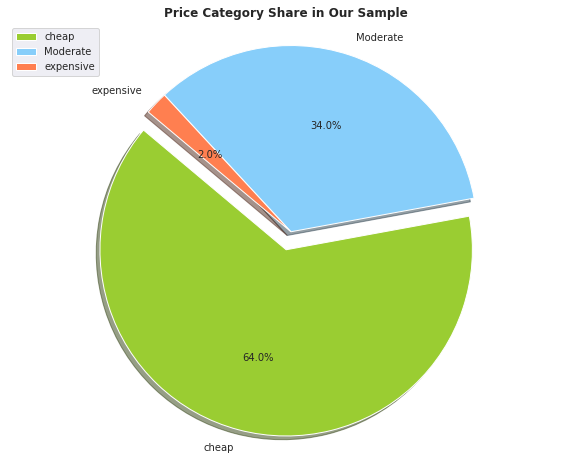

In [ ]:
## pie chart can be made to find the percentage of each body-style
labels = list(df['final_price'].unique())
sizes = list(df['final_price'].value_counts())
colors = ['yellowgreen', 'lightskyblue', 'coral']
explode = (0.1, 0, 0) # explode 1st slice
fig = plt.figure(figsize = (10,8))

# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)
plt.legend(labels, loc="best")

plt.title('Price Category Share in Our Sample', fontsize = 'large', fontweight = 'bold')
plt.axis('equal')
plt.show()

**Insights**

From the above pie chart maximum restaurants in the San Francisco fall under cheap bucket, least of them fall under expensive bucket

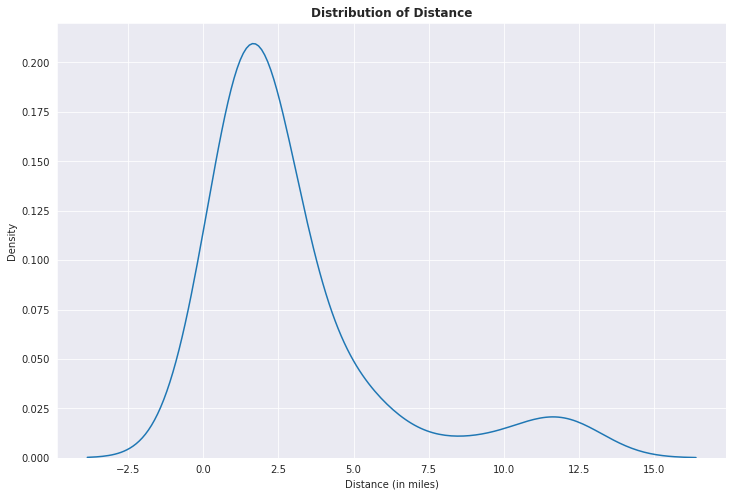

In [ ]:
#Distribution of Distance
plt.figure(figsize=(12,8))

sns.kdeplot(df.distance)

plt.title('Distribution of Distance', fontsize = 'large', fontweight = 'bold')
# plt.legend()
# plt.ylabel('Average Rating')
plt.xlabel('Distance (in miles)')
plt.show()


**Insights**

* Distribution of distance is right-skewed
* Most of the restaurants are near the city center (ie. distance < 2.5)

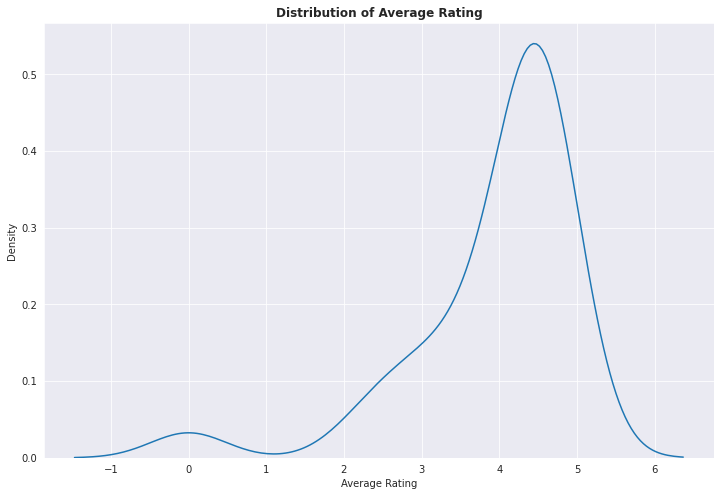

In [ ]:
#Distribution of Average Rating
plt.figure(figsize=(12,8))

sns.kdeplot(df.average_rating)

plt.title('Distribution of Average Rating', fontsize = 'large', fontweight = 'bold')
# plt.legend()
# plt.ylabel('Average Rating')
plt.xlabel('Average Rating')
plt.show()

**Insights**

* Distribution of average ratings in left-skewed
* Most of the ratings are in between 4 - 5 

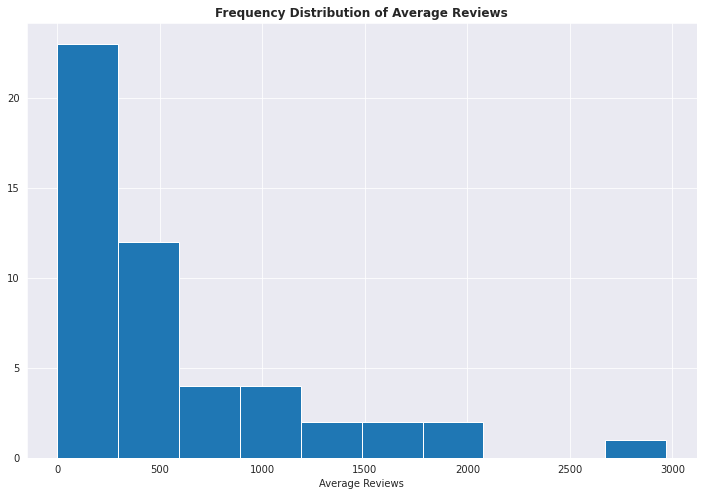

In [ ]:
#get the frequency graph of review count
plt.figure(figsize=(12,8))
plt.hist(df.average_reviews)

plt.title('Frequency Distribution of Average Reviews', fontsize = 'large', fontweight = 'bold')
# plt.legend()
plt.xlabel('Average Reviews')
plt.show()

**Insights**

* Most of the average count of reviews fall under 500
* Two restaurants have average count of reviews greater than 2000